# Processing hourly output from the WRF model

This notebook demonstrates how to derive daily precipitation totals from hourly WRF model data. It offers flexibility for calculating accumulations over user-defined time periods, specifically focusing on 24-hour totals (**00:00-24:00**) and **06:00-06:00** accumulations. We utilize two calculation approaches: 
- (1) summing hourly precipitation differences to obtain daily totals;
- (2) calculating the difference between accumulated precipitation at specific hours on consecutive days.



### Libraries import

In [304]:
import xarray as xr
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import cartopy
from datetime import datetime, timedelta
import os
import glob

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


### Functions

In [305]:
def calculate_daily_precipitation(wrf_file_pattern):
    """
    Calculates daily accumulated precipitation from WRF output files by summing.

    Args:
        wrf_file_pattern (str): Glob pattern for WRF output files.

    Returns:
        xr.DataArray: Daily accumulated precipitation DataArray.
    """

    # Step 1: Open WRF output files
    wrf_files = sorted(glob.glob(wrf_file_pattern))
    ds = xr.open_mfdataset(wrf_files, combine='by_coords')

    # Step 2: Compute total accumulated precipitation
    total_precip = ds['RAINNC'] + ds['RAINC']

    # Step 3: Compute hourly precipitation (incremental)
    incremental_precip = total_precip.diff(dim='XTIME')

    # Step 4: Preserve the first time step
    first_step = total_precip.isel(XTIME=0)
    incremental_precip = xr.concat([first_step, incremental_precip], dim='XTIME')

    # Step 5: Convert XTIME to Pandas datetime and shift by -1 hour
    time_values = pd.to_datetime(incremental_precip['XTIME'].values)
    shifted_time = time_values - pd.Timedelta(hours=1)

    # Step 6: Assign the shifted time back to XTIME
    incremental_precip = incremental_precip.assign_coords(XTIME=shifted_time)

    # Step 7: Compute daily accumulated precipitation
    daily_precip = incremental_precip.resample(XTIME="1D").sum()
    # Step 8: Reorder dimensions
    daily_precip = daily_precip.transpose('XTIME', 'south_north', 'west_east')

    return daily_precip

In [307]:

def calculate_daily_precipitation(wrf_file_pattern):
    """
    Calculates daily accumulated precipitation from WRF output files by summing and subtracting..

    Args:
        wrf_file_pattern (str): Glob pattern for WRF output files.

    Returns:
        tuple: A tuple containing two xr.DataArrays:
               - Daily accumulated precipitation (00:00 to 24:00) by summing over 24 hours of the day.
               - Accumulated precipitation from 06:00 today to 06:00 tomorrow by subtracting.
    """

    # Step 1: Open WRF output files
    wrf_files = sorted(glob.glob(wrf_file_pattern))
    ds = xr.open_mfdataset(wrf_files, combine='by_coords')

    # Step 2: Compute total accumulated precipitation
    total_precip = ds['RAINNC'] + ds['RAINC']

    # Step 3: Compute hourly precipitation (incremental)
    incremental_precip = total_precip.diff(dim='XTIME')

    # Step 4: Preserve the first time step
    first_step = total_precip.isel(XTIME=0)
    incremental_precip = xr.concat([first_step, incremental_precip], dim='XTIME')

    # Step 5: Convert XTIME to Pandas datetime and shift date by -1 hour because the total at 00:00:00 belongs to the previous day.
    #(so it will become 23:00:00 of the previous day).
    time_values = pd.to_datetime(incremental_precip['XTIME'].values)
    shifted_time = time_values - pd.Timedelta(hours=1)

    # Step 6: Assign the shifted time back to XTIME
    incremental_precip = incremental_precip.assign_coords(XTIME=shifted_time)

    # Step 7: Compute daily accumulated precipitation (00:00 to 24:00)
    daily_precip_00to24 = incremental_precip.resample(XTIME="1D").sum()

    # Step 8: Compute accumulated precipitation from 06:00 today to 06:00 tomorrow
    dates = pd.to_datetime(total_precip['XTIME'].values).date
    unique_dates = sorted(list(set(dates)))[:3] # Ensure only the first three days are processed because my forecast is for 78 hours
    daily_precip_06to06 = []

    for date in unique_dates:
        start_time = pd.to_datetime(f'{date} 06:00:00')
        end_time = pd.to_datetime(f'{date} 06:00:00') + pd.Timedelta(days=1)

        try:
            start_precip = total_precip.sel(XTIME=start_time, method='nearest')
            end_precip = total_precip.sel(XTIME=end_time, method='nearest')

            # Create a DataArray with the two time steps
            time_da = xr.concat([start_precip, end_precip], dim='XTIME')

            # Calculate the difference
            diff_da = time_da.diff(dim='XTIME')

            # Append the result
            daily_precip_06to06.append(diff_da)

        except Exception as e:
            print(f"Warning: Error processing {date}: {e}")
            # Create a NaN DataArray with the correct XTIME coordinate
            nan_data = total_precip.isel(XTIME=0).copy()
            nan_data[:] = np.nan
            nan_data = nan_data.assign_coords(XTIME=end_time)
            daily_precip_06to06.append(nan_data)

    if not daily_precip_06to06:
        print("Error: No valid data to concatenate for 06to06.")
        return daily_precip_00to24, None

    daily_precip_06to06 = xr.concat(daily_precip_06to06, dim='XTIME')
    daily_precip_06to06 = daily_precip_06to06.assign_coords(XTIME=pd.to_datetime(unique_dates))

    # Step 9: Reorder dimensions
    daily_precip_00to24 = daily_precip_00to24.transpose('XTIME', 'south_north', 'west_east')
    daily_precip_00to24 = daily_precip_00to24.sel(XTIME=slice(daily_precip_06to06.XTIME.min().values,daily_precip_06to06.XTIME.max().values))
    daily_precip_06to06 = daily_precip_06to06.transpose('XTIME', 'south_north', 'west_east')
    # Step 10: Add J+1, J+2, J+3 coordinates
    day_labels = ['J+1', 'J+2', 'J+3']
    daily_precip_00to24 = daily_precip_00to24.assign_coords(day_label=('XTIME', day_labels))
    daily_precip_06to06 = daily_precip_06to06.assign_coords(day_label=('XTIME', day_labels))


    return daily_precip_00to24, daily_precip_06to06

## Examples

In [308]:
# Example usage:
file_pattern = '/home/thomas/Course/WRF_ANAM/20240701/00h/wrfout_d02_2024-07-*.nc'
daily_precip_00to24,daily_precip_06to06 = calculate_daily_precipitation(file_pattern)



In [309]:
a1 = xr.open_mfdataset (file_pattern)
a1_precip =  (a1.RAINC + a1.RAINNC)

In [310]:
a1_precip

<xarray.DataArray (XTIME: 79, south_north: 288, west_east: 357)> Size: 32MB
dask.array<add, shape=(79, 288, 357), dtype=float32, chunksize=(1, 183, 357), chunktype=numpy.ndarray>
Coordinates:
  * XTIME    (XTIME) datetime64[ns] 632B 2024-07-01 ... 2024-07-04T06:00:00
    XLONG    (south_north, west_east) float32 411kB dask.array<chunksize=(288, 357), meta=np.ndarray>
    XLAT     (south_north, west_east) float32 411kB dask.array<chunksize=(288, 357), meta=np.ndarray>
Dimensions without coordinates: south_north, west_east

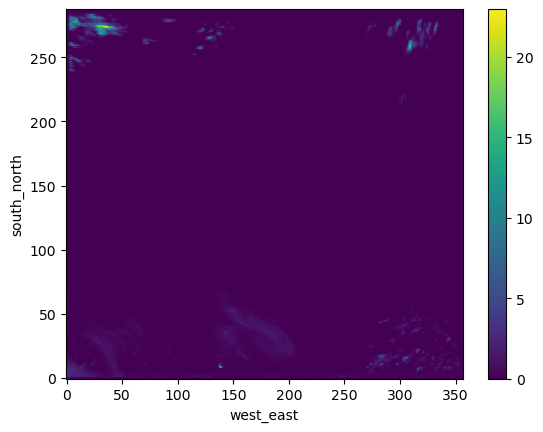

In [311]:
az = a1_precip.sel(XTIME='2024-07-02T00:00:00.000000000') - a1_precip.sel(XTIME='2024-07-01T00:00:00.000000000') 
az.plot()

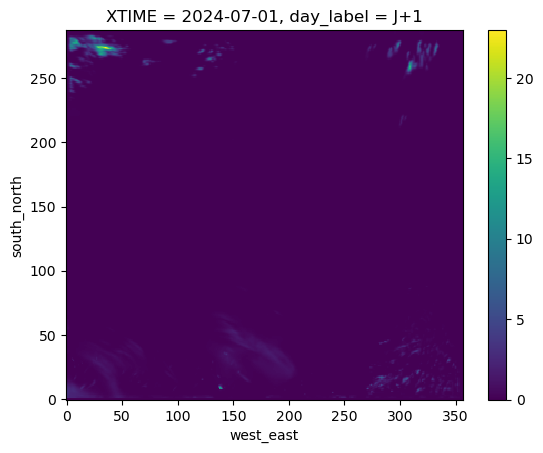

In [312]:
daily_precip_00to24[0,:,:].plot()

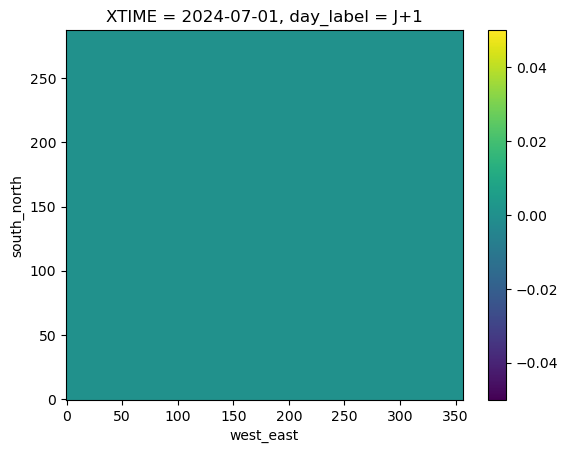

In [313]:
# this is an example to show the matching between subtrating and summing daily accumulation
# we round to make sure avoid mismach due to decimal
a0 = (daily_precip_00to24[0,:,:]-az).round(1).plot()

---
<div style="text-align: left;">
    <p style="font-size:14px;">
    <strong>Author:</strong> BERE R. Thomas<br>
    <strong>Affiliation:</strong> National Meteorological Agency of Burkina Faso<br>
    <strong>Date:</strong> 2025-03-04
    </p>
</div>
